In [14]:
# =========================
# [Cell 1] Google Drive 마운트 & 경로 설정 & 분석 CSV 탐지 (사전/사후 분리, NFKC)
# =========================
import os, sys, pathlib, glob, unicodedata
import pandas as pd

# --- Colab / 로컬 판단 ---
IN_COLAB = "google.colab" in sys.modules or "COLAB_GPU" in os.environ

if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive', force_remount=True)
    BASE_DIR = "/content/drive/MyDrive/colab"
else:
    BASE_DIR = os.path.expanduser("~/colab")

OUT_DIR = os.path.join(BASE_DIR, "output")
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

print("IN_COLAB:", IN_COLAB)
print("BASE_DIR:", BASE_DIR)
print("OUT_DIR :", OUT_DIR)

# --- 분석 결과 CSV 탐지: *_analysis.csv 전부 ---
pattern = os.path.join(OUT_DIR, "*_analysis.csv")
candidates = sorted(glob.glob(pattern))

print("\n[탐지된 *_analysis.csv 파일들]")
if not candidates:
    print("  (없음)")
else:
    for p in candidates:
        b_raw  = os.path.basename(p)
        b_norm = unicodedata.normalize("NFKC", b_raw)
        print(" - RAW :", b_raw)
        print("   NFKC:", b_norm)

if not candidates:
    raise FileNotFoundError(
        f"OUT_DIR({OUT_DIR}) 안에 *_analysis.csv 파일이 없습니다.\n"
        "예: 2025 교육연구프로그램 설문(응답)_analysis.csv\n"
        "    2025 교육연구프로그램 사후 설문(응답)_analysis.csv"
    )

# --- 사전/사후 분리 로직 (NFKC 정규화 후 검사) ---
pre_files_raw  = []
post_files_raw = []

for p in candidates:
    b_norm = unicodedata.normalize("NFKC", os.path.basename(p))
    if "사후" in b_norm:
        post_files_raw.append(p)
    elif "사전" in b_norm:
        pre_files_raw.append(p)
    else:
        print(f"[알림] '사전/사후' 인식 실패 → 임시로 사전으로 분류: {b_norm}")
        pre_files_raw.append(p)

def choose_one(files, kind_label="pre"):
    if not files:
        return None
    if len(files) == 1:
        return files[0]
    prefer = [p for p in files if "설문(응답)" in unicodedata.normalize("NFKC", os.path.basename(p))]
    if len(prefer) == 1:
        return prefer[0]
    if len(prefer) > 1:
        prefer = sorted(prefer)
        print(f"[알림] {kind_label} 후보 여러 개 → '설문(응답)' 포함 + 사전순 첫 번째 사용")
        return prefer[0]
    files = sorted(files)
    print(f"[알림] {kind_label} 후보 여러 개 → 사전순 첫 번째 사용")
    return files[0]

PRE_ANALYSIS_PATH  = choose_one(pre_files_raw,  kind_label="사전")
POST_ANALYSIS_PATH = choose_one(post_files_raw, kind_label="사후")

print("\n[사용할 분석 결과 파일]")
print("  사전 :", PRE_ANALYSIS_PATH)
print("  사후 :", POST_ANALYSIS_PATH)

if PRE_ANALYSIS_PATH is None and POST_ANALYSIS_PATH is None:
    raise RuntimeError("사전/사후 분석 파일을 전혀 찾지 못했습니다.")

# --- CSV 로드 ---
pre_df  = pd.read_csv(PRE_ANALYSIS_PATH)  if PRE_ANALYSIS_PATH  else None
post_df = pd.read_csv(POST_ANALYSIS_PATH) if POST_ANALYSIS_PATH else None

if pre_df is not None:
    df = pre_df.copy()
    CURRENT_SOURCE = "pre"
elif post_df is not None:
    df = post_df.copy()
    CURRENT_SOURCE = "post"
else:
    raise RuntimeError("사전/사후 중 어떤 것도 로드되지 않았습니다.")

print("\n[현재 df 설정]")
print(f"CURRENT_SOURCE = {CURRENT_SOURCE!r}")
print("df.shape =", df.shape)


Mounted at /content/drive
IN_COLAB: True
BASE_DIR: /content/drive/MyDrive/colab
OUT_DIR : /content/drive/MyDrive/colab/output

[탐지된 *_analysis.csv 파일들]
 - RAW : 2025 교육연구프로그램 사전 설문(응답)_analysis.csv
   NFKC: 2025 교육연구프로그램 사전 설문(응답)_analysis.csv
 - RAW : 2025 교육연구프로그램 사후 설문(응답)_analysis.csv
   NFKC: 2025 교육연구프로그램 사후 설문(응답)_analysis.csv
 - RAW : pre_post_Q1_Q6_total_by_student_2025 교육연구프로그램 사전 설문(응답)_analysis.csv
   NFKC: pre_post_Q1_Q6_total_by_student_2025 교육연구프로그램 사전 설문(응답)_analysis.csv
 - RAW : pre_post_delta_summary_robust_2025 교육연구프로그램 사전 설문(응답)_analysis.csv
   NFKC: pre_post_delta_summary_robust_2025 교육연구프로그램 사전 설문(응답)_analysis.csv
 - RAW : summary_by_question_2025 교육연구프로그램 사전 설문(응답)_analysis.csv
   NFKC: summary_by_question_2025 교육연구프로그램 사전 설문(응답)_analysis.csv
 - RAW : top10_mislabels_2025 교육연구프로그램 사전 설문(응답)_analysis.csv
   NFKC: top10_mislabels_2025 교

[INFO] Nanum 폰트 패키지 설치 시도 (fonts-nanum)...
[INFO] 폰트 등록: /usr/share/fonts/truetype/nanum/NanumGothic.ttf
[INFO] 폰트 등록: /usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf
[INFO] 폰트 등록: /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf

[통계 대상 파일 태그]: 2025 교육연구프로그램 사전 설문(응답)_analysis | 제목 라벨: 사전

[df 샘플]


,source_file,survey_phase,student_id,student_name,student_grade,question_id,question,answer,mislabels,score_judge,score_mech,score_extend,score_total,feedback,evidence_used,concept_flags,mislabel_list,is_ok,has_misconception
0,2025 교육연구프로그램 사전 설문(응답)....,사전,0,김지혜,대학교 2학년,Q1,1. 암흑물질(Dark Matter)과 암흑에너지(Dark Energy)를 각각 정...,"암흑물질은 눈에 보이지 않지만, 질량을 가진 물질을 의미한다. 암흑에너지는 우주를 ...",없음(정상),1,2,0,3,암흑물질=비발광(EM 상호작용 미약)·구조를 모음 / 암흑에너지=우주 가속 성분(음...,암흑에너지는 우주를 가속팽창하게 하는 에너지로 이용된다.,(정) DM↔DE 대비,[없음(정상)],True,False
1,2025 교육연구프로그램 사전 설문(응답)....,사전,0,김지혜,대학교 2학년,Q2,2. 암흑물질의 존재를 강력하게 지지하는 천문학적 관측 증거를 아는 대로 서술하세요.,"은하의 회전속도, 미세중력탐사",없음(정상),1,3,0,4,회전곡선 평탄·중력렌즈·은하단 동역학·CMB 중 1–2개를 축/오차와 함께 제시하세요.,NaN,(정) 회전곡선 평탄,[없음(정상)],True,False
2,2025 교육연구프로그램 사전 설문(응답)....,사전,0,김지혜,대학교 2학년,Q3,3. 암흑물질과 암흑에너지를 '암흑(Dark)'이라고 부르는 이유가 무엇이라고 생각...,눈에 보이지 않기 때문에,없음(정상),0,0,0,0,‘직접’은 어렵지만 중력 효과로 ‘간접 검출’ 가능함을 한 줄로 정리하세요.,NaN,NaN,[없음(정상)],True,False
3,2025 교육연구프로그램 사전 설문(응답)....,사전,0,김지혜,대학교 2학년,Q4,"4. 암흑물질의 후보로 언급되는 입자들의 특징을 설명하고, 왜 그런 특징을 보이는지...","윔프, 윔프는 질량이 무겁고, 다른 입자들과 상호작용이 적기 때문이다.",없음(정상),1,2,0,3,WIMP/액시온 등 ‘입자’ 후보 1–2개 + ‘약한 상호작용·질량 범위’가 관측/...,NaN,(정) 후보 명시,[없음(정상)],True,False
4,2025 교육연구프로그램 사전 설문(응답)....,사전,0,김지혜,대학교 2학년,Q5,"5. 1990년대 후반, 천문학자들이 우주의 '가속 팽창'을 발견하게 된 결정적인 ...","Ia 초신성 관측, 이 초신성은 표준광원인데, 그렇기 때문에 절대등급을 알 고 있다...",없음(정상),2,4,0,6,SN Ia 표준촛불: 더 어둡게 관측→더 멀다→과거 감속→지금 가속. 축/오차/모형...,"이때 초신성의 적색편이가 측정되어 가속팽창을 의미하게 된다.; Ia 초신성 관측, ...",(정) SN Ia 핵심 사슬,[없음(정상)],True,False



[문항별 요약표 저장]: /content/drive/MyDrive/colab/output/summary_by_question_2025 교육연구프로그램 사전 설문(응답)_analysis.csv


,question_id,n,ok_rate(%),mis_ans,score_median,score_min,score_max,score_std,score_mean,top3_mislabels
0,Q1,15,86.7,2,3.0,3,7,1.290994,3.666667,DM-DE 혼동(2)
1,Q2,15,100.0,0,4.0,0,7,1.897367,4.200000,
2,Q3,15,73.3,4,0.0,0,4,1.511858,1.000000,관측(4); 검출 혼동(4)
3,Q4,15,40.0,9,0.0,0,3,1.549193,1.400000,무응답(8); 비관련(8); 비후보(1)
4,Q5,15,80.0,3,6.0,0,8,2.414243,5.600000,무응답(2); 비관련(2); 기전(1)
5,Q6,15,80.0,3,3.0,0,3,1.125463,2.466667,분포(1); 역할 오해(1); 음모(1)
6,Q7,15,80.0,3,4.0,0,5,2.133631,2.466667,무응답(3); 비관련(3)


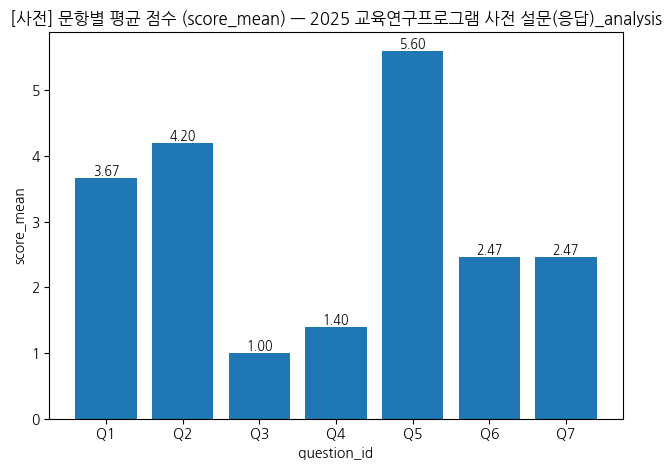

[그림 저장]: /content/drive/MyDrive/colab/output/D_score_mean_by_question_2025 교육연구프로그램 사전 설문(응답)_analysis.png


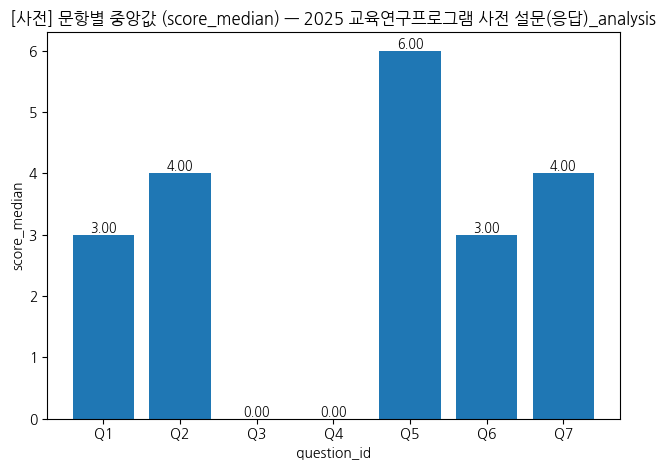

[그림 저장]: /content/drive/MyDrive/colab/output/E_score_median_by_question_2025 교육연구프로그램 사전 설문(응답)_analysis.png


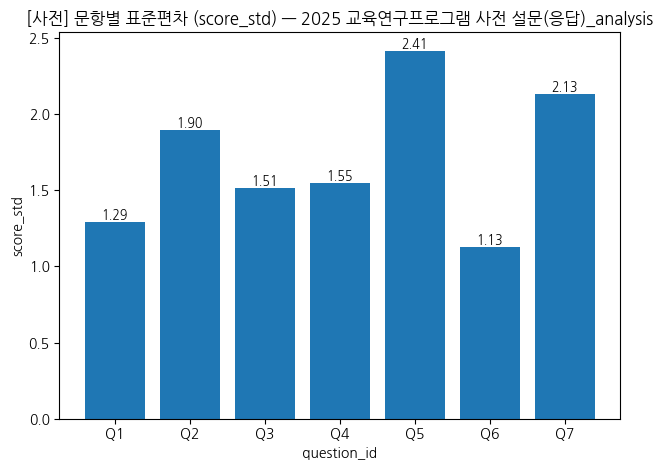

[그림 저장]: /content/drive/MyDrive/colab/output/F_score_std_by_question_2025 교육연구프로그램 사전 설문(응답)_analysis.png


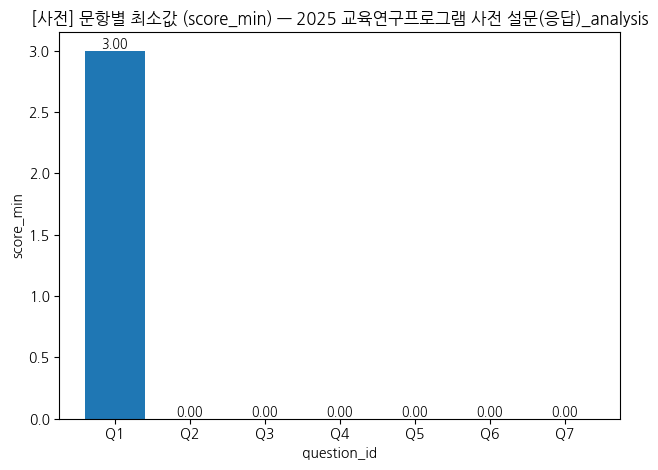

[그림 저장]: /content/drive/MyDrive/colab/output/G_score_min_by_question_2025 교육연구프로그램 사전 설문(응답)_analysis.png


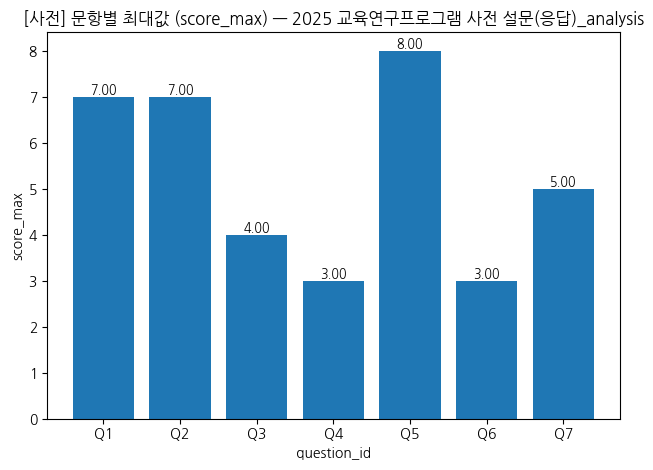

[그림 저장]: /content/drive/MyDrive/colab/output/H_score_max_by_question_2025 교육연구프로그램 사전 설문(응답)_analysis.png


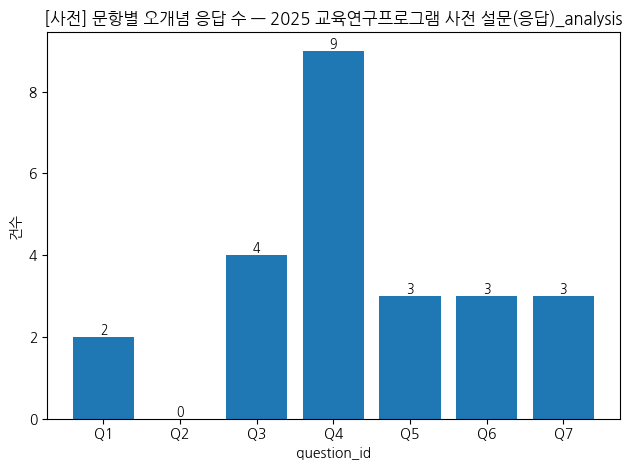

[그림 저장]: /content/drive/MyDrive/colab/output/I_mis_answers_by_question_2025 교육연구프로그램 사전 설문(응답)_analysis.png


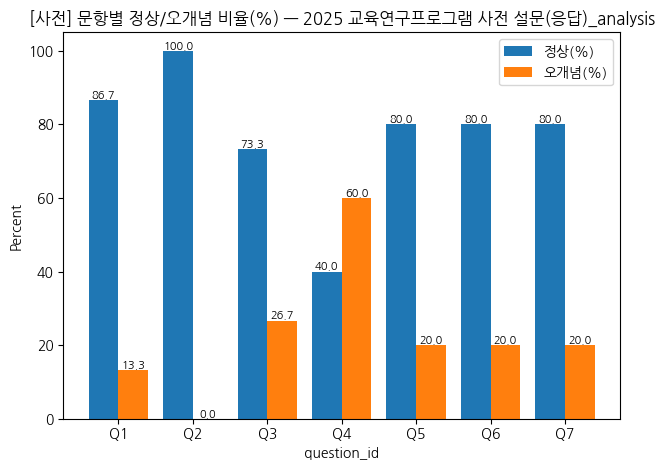

[그림 저장]: /content/drive/MyDrive/colab/output/J_ok_vs_mis_percent_by_question_2025 교육연구프로그램 사전 설문(응답)_analysis.png

[오개념 라벨 TOP10 저장]: /content/drive/MyDrive/colab/output/top10_mislabels_2025 교육연구프로그램 사전 설문(응답)_analysis.csv


,label,count
0,무응답,14
1,비관련,14
2,검출 혼동,4
3,관측,4
4,DM-DE 혼동,2
5,분포,2
6,역할 오해,2
7,단정,1
8,기전,1
9,비후보,1


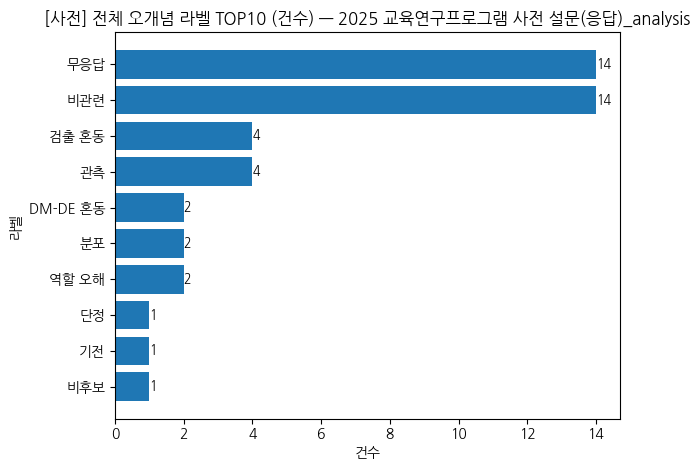

[그림 저장]: /content/drive/MyDrive/colab/output/K_top10_mislabels_overall_2025 교육연구프로그램 사전 설문(응답)_analysis.png

[완료] 통계/그래프 생성 & 저장 끝


In [15]:
# =========================
# [Cell 2] 문항별 통계 + 그래프 + 이름 리스트 (현재 df 기준)
# =========================
import os, re, unicodedata
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from IPython.display import display

IN_COLAB = "google.colab" in sys.modules or "COLAB_GPU" in os.environ

if "BASE_DIR" not in globals():
    BASE_DIR = "/content/drive/MyDrive/colab" if IN_COLAB else os.path.expanduser("~/colab")
if "OUT_DIR" not in globals():
    OUT_DIR = os.path.join(BASE_DIR, "output")
os.makedirs(OUT_DIR, exist_ok=True)

assert "df" in globals(), "Cell 1을 먼저 실행해서 df를 준비해 주세요."

# --- 한글 폰트 설정 ---
def setup_korean_font():
    target_font = "NanumGothic"
    if IN_COLAB:
        import subprocess
        try:
            print("[INFO] Nanum 폰트 패키지 설치 시도 (fonts-nanum)...")
            subprocess.run(["apt-get", "update"], check=False)
            subprocess.run(["apt-get", "-y", "install", "fonts-nanum"], check=False)
        except Exception as e:
            print("[WARN] apt-get 설치 중 오류:", e)
    candidate_paths = [
        "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
        "/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf",
        "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf",
    ]
    registered = False
    for p in candidate_paths:
        if os.path.exists(p):
            try:
                fm.fontManager.addfont(p); registered = True; print(f"[INFO] 폰트 등록: {p}")
            except Exception as e:
                print(f"[WARN] addfont 실패: {p} / {e}")
    mpl.rcParams["font.family"] = target_font if registered else "DejaVu Sans"
    mpl.rcParams["axes.unicode_minus"] = False

def save_and_show(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=150)
    plt.show(); plt.close(fig)
    print("[그림 저장]:", path)

def _to_labels(x):
    if pd.isna(x): return []
    parts = re.split(r"[,;/|]+", str(x))
    return [p.strip() for p in parts if p.strip()]

def _qid_from_text(x):
    s = str(x); m = re.match(r"^\s*(\d+)\s*[\.)]", s)
    return f"Q{int(m.group(1))}" if m else "Q?"

setup_korean_font()

# --- 파일 이름 태그(저장용) & 제목 라벨(표시용) ---
if "CURRENT_SOURCE" in globals() and CURRENT_SOURCE == "post" and "POST_ANALYSIS_PATH" in globals() and POST_ANALYSIS_PATH:
    raw_base_fn = os.path.splitext(os.path.basename(POST_ANALYSIS_PATH))[0]
else:
    raw_base_fn = os.path.splitext(os.path.basename(PRE_ANALYSIS_PATH))[0] if "PRE_ANALYSIS_PATH" in globals() else "analysis"

base_fn   = unicodedata.normalize("NFC", str(raw_base_fn))   # 저장 파일명용
SRC_LABEL = "사전" if globals().get("CURRENT_SOURCE") == "pre" else "사후"  # 제목용
def T(s): return f"[{SRC_LABEL}] {s} — {base_fn}"

print("\n[통계 대상 파일 태그]:", base_fn, "| 제목 라벨:", SRC_LABEL)

df = df.copy()
if "question_id" not in df.columns:
    if "question" in df.columns:
        df["question_id"] = df["question"].apply(_qid_from_text)
    else:
        raise KeyError("question_id 또는 question 컬럼이 필요합니다.")

score_cols = ["score_judge","score_mech","score_extend","score_total"]
for c in score_cols:
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")

if "score_total" not in df.columns:
    need = [c for c in ["score_judge","score_mech","score_extend"] if c in df.columns]
    df["score_total"] = df[need].sum(axis=1) if need else np.nan

if "mislabels" not in df.columns:
    df["mislabels"] = "무응답/비관련"

df["mislabel_list"] = df["mislabels"].apply(_to_labels)
df["is_ok"] = df["mislabel_list"].apply(lambda L: (len(L) == 1 and L[0] == "없음(정상)"))
df["has_misconception"] = df["mislabel_list"].apply(lambda L: any(x != "없음(정상)" for x in L))

print("\n[df 샘플]")
display(df.head(5))

# =========================================================
# 1. 문항별 요약표 & 오개념 TOP10
# =========================================================
from collections import Counter
def top_k_mislabels(labels_series, k=3):
    cnt = Counter()
    for L in labels_series:
        for x in L:
            if x != "없음(정상)": cnt[x] += 1
    return "; ".join([f"{lab}({n})" for lab, n in cnt.most_common(k)]) if cnt else ""

grp = df.groupby("question_id", dropna=False)
agg1 = grp.agg(n=("question_id","size"), ok_rate=("is_ok","mean"), mis_ans=("has_misconception","sum")).reset_index()

if df["score_total"].notna().any():
    agg2 = grp["score_total"].agg(["median","min","max","std","mean"]).reset_index().rename(
        columns={"median":"score_median","min":"score_min","max":"score_max","std":"score_std","mean":"score_mean"})
else:
    agg2 = pd.DataFrame({"question_id": agg1["question_id"]})

top3 = grp["mislabel_list"].apply(lambda s: top_k_mislabels(s, k=3)).reset_index().rename(columns={"mislabel_list":"top3_mislabels"})
summary = agg1.merge(agg2, on="question_id", how="left").merge(top3, on="question_id", how="left")
summary["ok_rate(%)"] = (summary["ok_rate"] * 100).round(1)
keep = ["question_id","n","ok_rate(%)","mis_ans","score_median","score_min","score_max","score_std","score_mean","top3_mislabels"]
for c in keep:
    if c not in summary.columns: summary[c] = np.nan
summary = summary[keep].sort_values("question_id")

summary_path = os.path.join(OUT_DIR, f"summary_by_question_{base_fn}.csv")
summary.to_csv(summary_path, index=False, encoding="utf-8-sig")
print("\n[문항별 요약표 저장]:", summary_path)
display(summary)

# =========================================================
# 2. 문항별 막대그래프 (D~K) — 제목: [사전]/[사후] … — base_fn
# =========================================================
x = summary["question_id"].astype(str).values

# 2-1) 평균
if summary["score_mean"].notna().any():
    fig, ax = plt.subplots()
    y = summary["score_mean"].values
    ax.bar(x, y)
    ax.set_title(T("문항별 평균 점수 (score_mean)"))
    ax.set_xlabel("question_id"); ax.set_ylabel("score_mean")
    for i, v in enumerate(y): ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
    save_and_show(fig, os.path.join(OUT_DIR, f"D_score_mean_by_question_{base_fn}.png"))

# 2-2) 중앙값
if summary["score_median"].notna().any():
    fig, ax = plt.subplots()
    y = summary["score_median"].values
    ax.bar(x, y)
    ax.set_title(T("문항별 중앙값 (score_median)"))
    ax.set_xlabel("question_id"); ax.set_ylabel("score_median")
    for i, v in enumerate(y): ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
    save_and_show(fig, os.path.join(OUT_DIR, f"E_score_median_by_question_{base_fn}.png"))

# 2-3) 표준편차
if summary["score_std"].notna().any():
    fig, ax = plt.subplots()
    y = summary["score_std"].fillna(0).values
    ax.bar(x, y)
    ax.set_title(T("문항별 표준편차 (score_std)"))
    ax.set_xlabel("question_id"); ax.set_ylabel("score_std")
    for i, v in enumerate(y): ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
    save_and_show(fig, os.path.join(OUT_DIR, f"F_score_std_by_question_{base_fn}.png"))

# 2-4) 최소/최대
for col, fname, title in [
    ("score_min", f"G_score_min_by_question_{base_fn}.png", "문항별 최소값 (score_min)"),
    ("score_max", f"H_score_max_by_question_{base_fn}.png", "문항별 최대값 (score_max)")
]:
    if summary[col].notna().any():
        fig, ax = plt.subplots()
        y = summary[col].values
        ax.bar(x, y)
        ax.set_title(T(title))
        ax.set_xlabel("question_id"); ax.set_ylabel(col)
        for i, v in enumerate(y): ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
        save_and_show(fig, os.path.join(OUT_DIR, fname))

# 2-5) 문항별 오개념 수
fig, ax = plt.subplots()
y = summary["mis_ans"].values
ax.bar(x, y)
ax.set_title(T("문항별 오개념 응답 수"))
ax.set_xlabel("question_id"); ax.set_ylabel("건수")
for i, v in enumerate(y): ax.text(i, v, f"{int(v)}", ha="center", va="bottom", fontsize=9)
save_and_show(fig, os.path.join(OUT_DIR, f"I_mis_answers_by_question_{base_fn}.png"))

# 2-6) 정상/오개념 비율
ok_percent  = summary["ok_rate(%)"].values
total_n     = summary["n"].values
mis_percent = np.where(total_n > 0, (summary["mis_ans"].values / total_n) * 100.0, 0.0)

fig, ax = plt.subplots()
idx = np.arange(len(x)); bw = 0.4
ax.bar(idx - bw/2, ok_percent,  width=bw, label="정상(%)")
ax.bar(idx + bw/2, mis_percent, width=bw, label="오개념(%)")
ax.set_xticks(idx); ax.set_xticklabels(x)
ax.set_title(T("문항별 정상/오개념 비율(%)"))
ax.set_xlabel("question_id"); ax.set_ylabel("Percent")
ax.legend()
for i, v in enumerate(ok_percent):  ax.text(i - bw/2, v, f"{v:.1f}", ha="center", va="bottom", fontsize=8)
for i, v in enumerate(mis_percent): ax.text(i + bw/2, v, f"{v:.1f}", ha="center", va="bottom", fontsize=8)
save_and_show(fig, os.path.join(OUT_DIR, f"J_ok_vs_mis_percent_by_question_{base_fn}.png"))

# 2-7) 오개념 TOP10 막대그래프
# (라벨: [사전]/[사후]로 명확히)
all_rows = []
for _, r in df.iterrows():
    qid = r["question_id"]; L = r["mislabel_list"]
    if L:
        for lab in L: all_rows.append((qid, lab, 1))
    else:
        all_rows.append((qid, "무응답/비관련", 1))
lab_df = pd.DataFrame(all_rows, columns=["question_id","label","cnt"])
mis_only = lab_df[lab_df["label"] != "없음(정상)"]
top10 = (
    mis_only.groupby("label")["cnt"].sum()
    .sort_values(ascending=False).head(10)
    .reset_index().rename(columns={"cnt":"count"})
)

top10_path = os.path.join(OUT_DIR, f"top10_mislabels_{base_fn}.csv")
top10.to_csv(top10_path, index=False, encoding="utf-8-sig")
print("\n[오개념 라벨 TOP10 저장]:", top10_path)
display(top10)

if not top10.empty:
    fig, ax = plt.subplots()
    labs = top10["label"].astype(str).values
    cnts = top10["count"].values
    ax.barh(labs[::-1], cnts[::-1])
    ax.set_title(T("전체 오개념 라벨 TOP10 (건수)"))
    ax.set_xlabel("건수"); ax.set_ylabel("라벨")
    for i, v in enumerate(cnts[::-1]):
        ax.text(v, i, f"{int(v)}", va="center", ha="left", fontsize=9)
    save_and_show(fig, os.path.join(OUT_DIR, f"K_top10_mislabels_overall_{base_fn}.png"))

print("\n[완료] 통계/그래프 생성 & 저장 끝")


In [16]:
# =========================
# [Cell 3] (사전) Q7 제외(Q1~Q6) 학생별 총점 + 등수
# =========================
import os, re
import numpy as np
import pandas as pd
from IPython.display import display

assert "pre_df" in globals(), "Cell 1에서 pre_df를 먼저 로드해야 합니다."

df_pre = pre_df.copy()

def _qid_from_text(x):
    s = str(x); m = re.match(r"^\s*(\d+)\s*[\.)]", s)
    return f"Q{int(m.group(1))}" if m else "Q?"

if "question_id" not in df_pre.columns:
    if "question" in df_pre.columns:
        df_pre["question_id"] = df_pre["question"].apply(_qid_from_text)
    else:
        raise KeyError("question_id 또는 question 컬럼이 필요합니다.")

for c in ["score_judge","score_mech","score_extend","score_total"]:
    if c in df_pre.columns: df_pre[c] = pd.to_numeric(df_pre[c], errors="coerce")

df_pre_noQ7 = df_pre[df_pre["question_id"] != "Q7"].copy()
df_pre_noQ7["student_name"]  = df_pre_noQ7["student_name"].astype(str).str.strip()
df_pre_noQ7["student_grade"] = df_pre_noQ7["student_grade"].astype(str).str.strip()

agg_pre = (
    df_pre_noQ7
    .groupby(["student_name","student_grade"], as_index=False)
    .agg(
        total_Q1_Q6=("score_total","sum"),
        n_questions=("question_id","nunique"),
        mean_per_question=("score_total","mean")
    )
)
agg_pre["rank_Q1_Q6"] = agg_pre["total_Q1_Q6"].rank(method="min", ascending=False).astype(int)
agg_pre = agg_pre.sort_values(["total_Q1_Q6","student_name"], ascending=[False, True])

if "OUT_DIR" not in globals():
    BASE_DIR = "/content/drive/MyDrive/colab" if "google.colab" in sys.modules else os.path.expanduser("~/colab")
    OUT_DIR = os.path.join(BASE_DIR, "output")
    os.makedirs(OUT_DIR, exist_ok=True)

out_path = os.path.join(OUT_DIR, "pre_total_Q1_Q6_by_student.csv")
agg_pre.to_csv(out_path, index=False, encoding="utf-8-sig")

print("[저장 완료] 사전 Q1~Q6 총점/등수:", out_path)
display(agg_pre)


[저장 완료] 사전 Q1~Q6 총점/등수: /content/drive/MyDrive/colab/output/pre_total_Q1_Q6_by_student.csv


,student_name,student_grade,total_Q1_Q6,n_questions,mean_per_question,rank_Q1_Q6
9,이승화,대학교 1학년,26,6,4.333333,1
7,이서호,대학교 3학년,24,6,4.000000,2
2,김한슬,대학교 1학년,21,6,3.500000,3
10,이윤주,대학교 1학년,21,6,3.500000,3
3,박서현,대학교 2학년,20,6,3.333333,5
6,이도향,대학교 1학년,20,6,3.333333,5
0,김지혜,대학교 2학년,19,6,3.166667,7
4,소지원,대학교 2학년,19,6,3.166667,7
8,이승준,대학교 1학년,19,6,3.166667,7
12,이채원,대학교 3학년,19,6,3.166667,7


[저장] 학생별 총점 변화: /content/drive/MyDrive/colab/output/pre_post_Q1_Q6_total_by_student_2025 교육연구프로그램 사전 설문(응답)_analysis.csv

[보정된 통계 요약]
- median_delta: 중앙값 (아웃라이어 무시)
- trimmed_mean_delta: 상하위 1명씩 뺀 평균


,question_id,n_students,mean_pre,mean_post,mean_delta,median_delta,trimmed_mean_delta
0,Q1,6,3.83,3.83,0.00,0.0,0.25
1,Q2,6,4.50,3.67,-0.83,-1.5,-1.25
2,Q3,6,0.83,1.67,0.83,0.0,0.75
3,Q4,6,2.00,3.17,1.17,0.5,1.00
4,Q5,6,6.67,5.83,-0.83,-1.0,-1.00
5,Q6,6,2.50,2.00,-0.50,0.0,-0.75


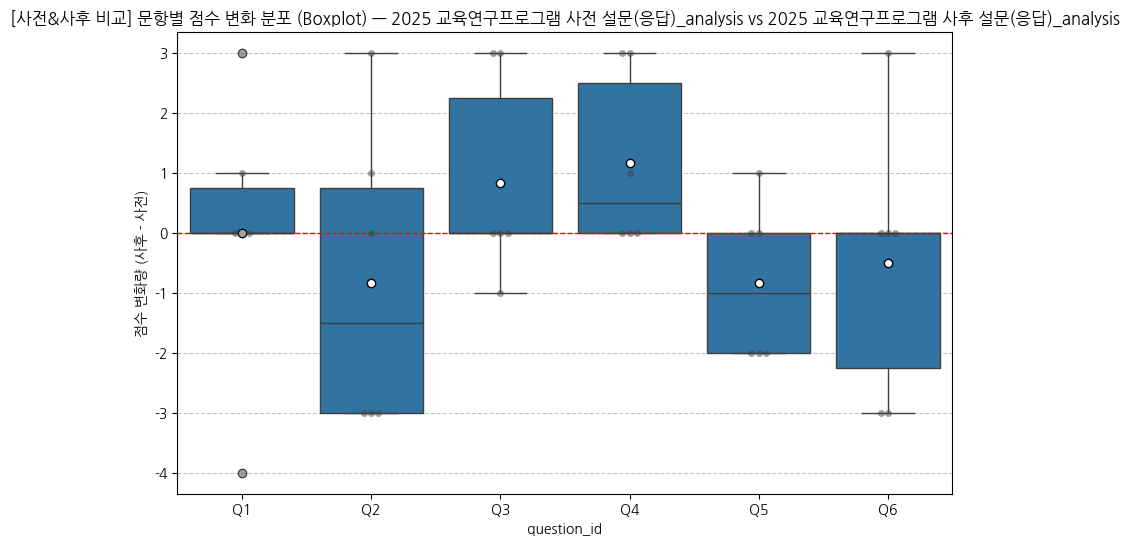

[그래프 저장] /content/drive/MyDrive/colab/output/boxplot_delta_score_2025 교육연구프로그램 사전 설문(응답)_analysis.png


In [17]:
# =========================
# [Cell 4] 사전/사후 응답자 Q1~Q6 점수 변화 분석 및 통계 보정
# =========================
import os, re, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

def to_nfc(text):
    if not isinstance(text, str): return str(text)
    return unicodedata.normalize('NFC', text)

assert "pre_df" in globals(),  "Cell 1에서 pre_df를 먼저 로드해야 합니다."
assert "post_df" in globals(), "Cell 1에서 post_df를 먼저 로드해야 합니다."
if post_df is None:
    raise RuntimeError("사후 설문 분석파일(post_df)이 없습니다.")

def _qid_from_text(x):
    s = str(x); m = re.match(r"^\s*(\d+)\s*[\.)]", s)
    return f"Q{int(m.group(1))}" if m else "Q?"

def _prep(df_):
    df = df_.copy()
    if "question_id" not in df.columns:
        if "question" in df.columns:
            df["question_id"] = df["question"].apply(_qid_from_text)
        else:
            raise KeyError("question_id 또는 question 컬럼이 필요합니다.")
    for c in ["score_judge","score_mech","score_extend","score_total"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    df["student_name"]  = df["student_name"].astype(str).apply(to_nfc).str.strip()
    df["student_grade"] = df["student_grade"].astype(str).apply(to_nfc).str.strip()
    return df

pre = _prep(pre_df); post = _prep(post_df)
pre_noQ7  = pre[pre["question_id"] != "Q7"].copy()
post_noQ7 = post[post["question_id"] != "Q7"].copy()

# 4-1. 학생별 총점 변화
stu_pre  = pre_noQ7.groupby(["student_name","student_grade"], as_index=False).agg(total_pre=("score_total","sum"))
stu_post = post_noQ7.groupby(["student_name","student_grade"], as_index=False).agg(total_post=("score_total","sum"))
stu_pair = stu_pre.merge(stu_post, on=["student_name","student_grade"], how="inner")

if stu_pair.empty:
    print("[경고] 매칭된 학생이 없습니다.")
else:
    stu_pair["delta_total"] = stu_pair["total_post"] - stu_pair["total_pre"]
    base_name = "pre_post_Q1_Q6_total_by_student"
    if "base_fn" in globals(): base_name += f"_{to_nfc(base_fn)}"
    out_path_stu = os.path.join(OUT_DIR, f"{base_name}.csv")
    stu_pair.to_csv(out_path_stu, index=False, encoding="utf-8-sig")
    print(f"[저장] 학생별 총점 변화: {out_path_stu}")

# 4-2. 문항별(Q1~Q6) 점수 변화 (통계 보정 포함)
key_q = ["student_name","student_grade","question_id"]
pre_q  = pre_noQ7.groupby(key_q,  as_index=False).agg(score_total_pre=("score_total","mean"))
post_q = post_noQ7.groupby(key_q, as_index=False).agg(score_total_post=("score_total","mean"))
q_pair = pre_q.merge(post_q, on=key_q, how="inner")

if not q_pair.empty:
    q_pair["delta_total"] = q_pair["score_total_post"] - q_pair["score_total_pre"]

    def trimmed_mean(series):
        if len(series) <= 2: return series.mean()
        return series.sort_values().iloc[1:-1].mean()

    q_summary = q_pair.groupby("question_id", as_index=False).agg(
        n_students=("student_name", "nunique"),
        mean_pre=("score_total_pre", "mean"),
        mean_post=("score_total_post", "mean"),
        mean_delta=("delta_total", "mean"),
        median_delta=("delta_total", "median"),
        trimmed_mean_delta=("delta_total", trimmed_mean)
    ).sort_values("question_id")

    cols_round = ["mean_pre", "mean_post", "mean_delta", "median_delta", "trimmed_mean_delta"]
    q_summary[cols_round] = q_summary[cols_round].round(2)

    out_path_summary = os.path.join(OUT_DIR, f"pre_post_delta_summary_robust_{to_nfc(base_fn)}.csv")
    q_summary.to_csv(out_path_summary, index=False, encoding="utf-8-sig")

    print("\n[보정된 통계 요약]")
    print("- median_delta: 중앙값 (아웃라이어 무시)")
    print("- trimmed_mean_delta: 상하위 1명씩 뺀 평균")
    display(q_summary)

    # ---- 제목 라벨: [사전&사후 비교] + 파일명 요약 ----
    pre_name  = os.path.splitext(os.path.basename(PRE_ANALYSIS_PATH))[0]  if "PRE_ANALYSIS_PATH"  in globals() and PRE_ANALYSIS_PATH  else "PRE"
    post_name = os.path.splitext(os.path.basename(POST_ANALYSIS_PATH))[0] if "POST_ANALYSIS_PATH" in globals() and POST_ANALYSIS_PATH else "POST"
    pre_name  = to_nfc(pre_name); post_name = to_nfc(post_name)
    PAIR_LABEL = "[사전&사후 비교]"

    # [시각화] 문항별 점수 변화 Boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="question_id", y="delta_total", data=q_pair, showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
    sns.swarmplot(x="question_id", y="delta_total", data=q_pair, color=".25", alpha=0.5)
    plt.axhline(0, color='r', linestyle='--', linewidth=1)

    plt.title(to_nfc(f"{PAIR_LABEL} 문항별 점수 변화 분포 (Boxplot) — {pre_name} vs {post_name}"))
    plt.ylabel("점수 변화량 (사후 - 사전)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plot_path = os.path.join(OUT_DIR, f"boxplot_delta_score_{to_nfc(base_fn)}.png")
    plt.savefig(plot_path, dpi=150); plt.show()
    print(f"[그래프 저장] {plot_path}")
